In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import Empirical, InverseGamma, Normal

plt.style.use('ggplot')

In [4]:
def multilevel( J, sigma, mu0 = 10, eta_tau0 = 1 ):
   mu    = Normal( loc = tf.zeros( 1 ), scale = mu0*tf.ones( 1 ) )
   eta   = Normal( loc = tf.zeros( J ), scale = eta_tau0*tf.ones( J ) )
   tau   = InverseGamma( concentration = tf.ones( 1 ), rate = tf.ones( 1 ))
   theta = mu + tf.multiply( tau, eta )
   y     = Normal( loc = theta, scale = tf.cast( sigma, tf.float32 ) )
   return {'y': y, 'mu': mu, 'eta': eta, 'tau': tau, 'theta': theta }


In [5]:
schools_dat = dict(
   mu0      = 10,
   eta_tau0 = 1.0,
   J        = 8,
   y        = [28,  8, -3,  7, -1,  1, 18, 12],
   sigma    = [15, 10, 16, 11,  9, 11, 10, 18]
)

In [6]:
def multilevel_sghmc ( J, mu0, eta_tau0, MCMC_samples = 1000  ):
   q_mu = Empirical( params = tf.Variable(tf.random_normal(shape = [MCMC_samples, 1],mean=mu0,stddev=20)) )
   q_eta = Empirical( tf.Variable(tf.random_normal(shape = [MCMC_samples, J], stddev = eta_tau0*tf.ones( [MCMC_samples, J] ) )) )
   q_tau = Empirical( tf.Variable(1.0/tf.random_gamma(shape = [MCMC_samples,1],alpha=1.0,beta=1.0)) )
   return {'q_mu': q_mu, 'q_eta': q_eta, 'q_tau': q_tau}


In [8]:
y_model =  multilevel( J = schools_dat['J'], sigma = schools_dat['sigma'], mu0 = schools_dat['mu0'], eta_tau0 = schools_dat['eta_tau0']  )


In [9]:
print(y_model)

{'y': <ed.RandomVariable 'Normal_8/' shape=(8,) dtype=float32>, 'mu': <ed.RandomVariable 'Normal_2/' shape=(1,) dtype=float32>, 'eta': <ed.RandomVariable 'Normal_5/' shape=(8,) dtype=float32>, 'tau': <ed.RandomVariable 'InverseGamma_2/' shape=(1,) dtype=float32>, 'theta': <tf.Tensor 'Add:0' shape=(8,) dtype=float32>}


In [10]:
N_samples = 10000
q_vars = multilevel_sghmc( schools_dat['J'], mu0 = schools_dat['mu0'], eta_tau0 = schools_dat['eta_tau0'],MCMC_samples = N_samples  )

In [11]:
print(q_vars)

{'q_mu': <ed.RandomVariable 'Empirical_2/' shape=(1,) dtype=float32>, 'q_eta': <ed.RandomVariable 'Empirical_5/' shape=(8,) dtype=float32>, 'q_tau': <ed.RandomVariable 'Empirical_8/' shape=(1,) dtype=float32>}


In [12]:
sess = ed.get_session()
tf.global_variables_initializer().run( )

# Stochastic Gradient Hamiltonian Monte Carlo
inference = ed.SGHMC(
    {y_model['mu']: q_vars['q_mu'], y_model['eta']: q_vars['q_eta'], y_model['tau']: q_vars['q_tau'] },
    data ={y_model['y']: tf.cast( schools_dat['y'], tf.float32).eval()}
)
inference.initialize()


In [13]:
inference.run( n_iter = N_samples, n_print = 100 )

10000/10000 [100%] ██████████████████████████████ Elapsed: 6s | Acceptance Rate: 1.000


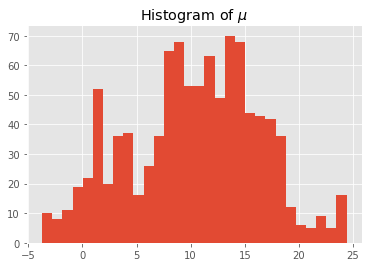

In [14]:
plt.hist(q_vars['q_mu'].sample(1000).eval(),bins=30)
plt.title("Histogram of $\mu$")
plt.show()

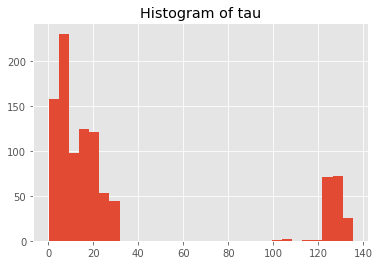

In [15]:
plt.hist(q_vars['q_tau'].sample(1000).eval(),bins=30)
plt.title("Histogram of tau")
plt.show()

In [16]:
theta_sample = q_vars['q_mu'].sample(1000) + q_vars['q_tau'].sample(1000)*q_vars['q_eta'].sample(1000)

theta_post   = tf.reduce_mean(theta_sample,0).eval()
print( theta_post )

[  7.61578894   9.12781334   9.66191196  19.25716209   8.55209923
  12.43373489  10.46726227  14.87581158]


In [ ]:
sess.close()

In [17]:
print( schools_dat )

{'mu0': 10, 'eta_tau0': 1.0, 'J': 8, 'y': [28, 8, -3, 7, -1, 1, 18, 12], 'sigma': [15, 10, 16, 11, 9, 11, 10, 18]}
